# MLP from scratch

In this homework, you will code a [Multilayer perceptron](https://en.wikipedia.org/wiki/Multilayer_perceptron) with one hidden layer to classify text data.

Advice:
- As much as possible, please try to make matrix and vector operations (good practice for efficient code)
- If you're not familiar with numpy, check the documentation of `np.max`, `np.clip`, `np.random.randn`, `np.reshape`. FYI the matrix multiplication operator is `@`, and you may want to learn about [broadcasting rules](https://numpy.org/doc/stable/user/basics.broadcasting.html) to see how it deals with tensor operations of different sizes
- You can also check about `torch.clamp`, `torch.nn.Parameter`

## 1. Some utilities and dataset for Part 2

Linear Class:
class that represents a fully connected (dense) layer, the ReLU class that represents a Rectified Linear Unit (ReLU) activation function, and the Sigmoid class that represents a Sigmoid activation function.
Then we implement the Sequential class and train it.

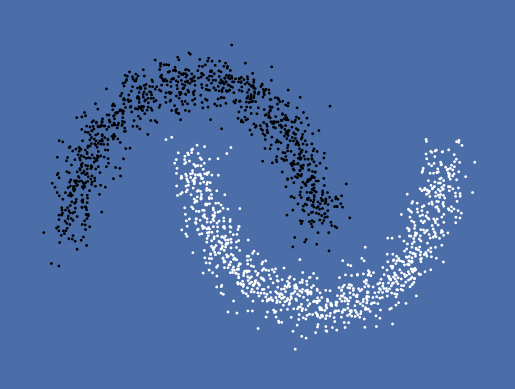

Epoch 1/100, Loss: 0.7927824940575356
Epoch 2/100, Loss: 3.4220310813619736
Epoch 3/100, Loss: 13.820724337482202
Epoch 4/100, Loss: 13.806061695963939
Epoch 5/100, Loss: 13.735261849920791
Epoch 6/100, Loss: 10.412253481142015
Epoch 7/100, Loss: 13.346758039326744
Epoch 8/100, Loss: 5.388336481444614
Epoch 9/100, Loss: 5.22597170324199
Epoch 10/100, Loss: 5.000584681286076
Epoch 11/100, Loss: 4.761197322752489
Epoch 12/100, Loss: 4.600560619973905
Epoch 13/100, Loss: 4.175515244335311
Epoch 14/100, Loss: 3.778956093735157
Epoch 15/100, Loss: 3.553183537850021
Epoch 16/100, Loss: 3.4209974725075973
Epoch 17/100, Loss: 3.114536788665143
Epoch 18/100, Loss: 2.987108464363704
Epoch 19/100, Loss: 3.018788374398805
Epoch 20/100, Loss: 2.9926136577108537
Epoch 21/100, Loss: 3.2817104658530805
Epoch 22/100, Loss: 2.9561174634018563
Epoch 23/100, Loss: 2.895428780697565
Epoch 24/100, Loss: 3.2729807364679115
Epoch 25/100, Loss: 2.8994869091891218
Epoch 26/100, Loss: 3.068706652756995
Epoch 27/

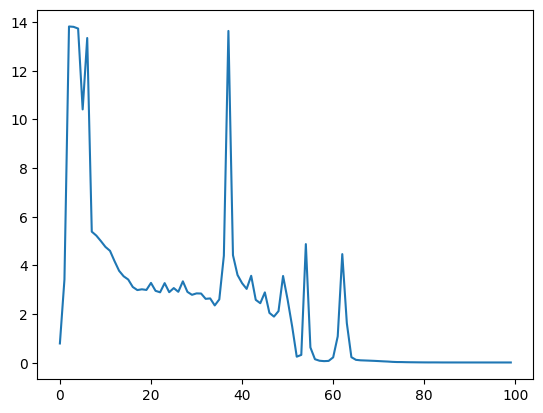

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate and plot the data
def plot_data(ax, X, Y):
     plt.axis('off')
     ax.scatter(X[:, 0], X[:, 1], s=1, c=Y, cmap='bone')

X, Y = make_moons(n_samples=2000, noise=0.1)

x_min, x_max = -1.5, 2.5
y_min, y_max = -1, 1.5
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_data(ax, X, Y)
plt.show()

# Define the layers
class Linear:
     def __init__(self, input_dim: int, output_dim: int):
         self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2. / input_dim)
         self.bias = np.zeros((1, output_dim))

     def forward(self, X: np.ndarray):
         self.X = X
         return X @ self.weights + self.bias

     def backward(self, grad: np.ndarray):
         self.grad_w = self.X.T @ grad
         self.grad_b = np.sum(grad, axis=0)
         return grad @ self.weights.T

     def step(self, learning_rate: float):
         self.weights -= learning_rate * self.grad_w
         self.bias -= learning_rate * self.grad_b

class ReLU:
     def forward(self, X: np.ndarray):
         self.X = X
         return np.maximum(0, X)

     def backward(self, grad: np.ndarray):
         return grad * (self.X > 0)

     def step(self, learning_rate: float):
         pass

class Sigmoid:
    def forward(self, X: np.ndarray):
        self.X = X
        return 1 / (1 + np.exp(-X))

    def backward(self, grad: np.ndarray):
        sigmoid = self.forward(self.X)
        return grad * sigmoid * (1 - sigmoid)

    def step(self, learning_rate: float):
        pass

# Define the model
class Sequential:
     def __init__(self, *args):
         self.layers = args

     def forward(self, X: np.ndarray):
         for layer in self.layers:
             X = layer.forward(X)
         return X

     def backward(self, grad: np.ndarray):
         for layer in reversed(self.layers):
             grad = layer.backward(grad)

     def step(self, learning_rate: float):
         for layer in self.layers:
             layer.step(learning_rate)

     def train(self, X: np.ndarray, y: np.ndarray, epochs: int, learning_rate: float):
         history = []

         for i in range(epochs):
             y_pred = self.forward(X)
             loss = self.binary_cross_entropy(y, y_pred)
             print(f'Epoch {i+1}/{epochs}, Loss: {loss}')
             history.append(loss)
             grad = self.grad_binary_cross_entropy(y, y_pred)
             self.backward(grad)
             self.step(learning_rate)

         return history

     @staticmethod
     def binary_cross_entropy(y: np.ndarray, y_pred: np.ndarray):
         epsilon = 1e-12 # to avoid taking log of zero
         return -np.mean(y * np.log(y_pred + epsilon) + (1 - y) * np.log(1 - y_pred + epsilon))

     @staticmethod
     def grad_binary_cross_entropy(y: np.ndarray, y_pred: np.ndarray):
         epsilon = 1e-12 # to avoid division by zero
         return - (y / (y_pred + epsilon)) + ((1 - y) / (1 - y_pred + epsilon))

# Instantiate the model
model = Sequential(
     Linear(2, 64),
     ReLU(),
     Linear(64, 1),
     Sigmoid(),
)

# Reshape the target variable to be a 2D array
Y = Y.reshape(-1, 1)

# Train the model
history = model.train(X, Y, epochs=100, learning_rate=0.01)

# Plot loss history
plt.plot(history)
plt.show()


## 2. MLP in numpy

Here you need to code your implementation of the [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation and the [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function).

In [14]:
class MyReLU(object):
    def forward(self, x):
        # the relu is y_i = max(0, x_i)
        # YOUR CODE HERE
        raise NotImplementedError()
        
    
    def backward(self, grad_output):
        # the gradient is 1 for the inputs that were above 0, 0 elsewhere
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here, since ReLU has no parameters
        # YOUR CODE HERE
        raise NotImplementedError()

class MySigmoid(object):
    def forward(self, x):
        # the sigmoid is y_i = 1./(1+exp(-x_i))
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def backward(self, grad_output):
        # the partial derivative is e^-x / (e^-x + 1)^2
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # no need to do anything here since Sigmoid has no parameters
        # YOUR CODE HERE
        raise NotImplementedError()

Probably a good time to test your functions...

In [15]:
test_relu = MyReLU()
test_relu.forward([0, -1, 0.5, -0.5, 0.8, 1])

NotImplementedError: 

In [ ]:
test_relu.backward(np.ones(1))

NameError: name 'test_relu' is not defined

In [16]:
test_sig = MySigmoid()

test_sig.forward(np.ones(1))

NotImplementedError: 

In [ ]:
test_sig.backward(np.ones(1))

A bit more complicated, you need now to implement your linear layer i.e. multiplication by a matrix W and summing with a bias b.

In [ ]:
class MyLinear(object):
    def __init__(self, n_input, n_output):
        # initialize two random matrices for W and b (use np.random.randn)
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # save a copy of x, you'll need it for the backward
        # return Wx + b
        # YOUR CODE HERE
        raise NotImplementedError()

    def backward(self, grad_output):
        # y_i = \sum_j W_{i,j} x_j + b_i
        # d y_i / d W_{i, j} = x_j
        # d loss / d y_i = grad_output[i]
        # so d loss / d W_{i,j} = x_j * grad_output[i]  (by the chain rule)
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # d y_i / d b_i = 1
        # d loss / d y_i = grad_output[i]
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # now we need to compute the gradient with respect to x to continue the back propagation
        # d y_i / d x_j = W_{i, j}
        # to compute the gradient of the loss, we have to sum over all possible y_i in the chain rule
        # d loss / d x_j = \sum_i (d loss / d y_i) (d y_i / d x_j)
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # update self.W and self.b in the opposite direction of the stored gradients, for learning_rate
        # YOUR CODE HERE
        raise NotImplementedError()

Code your network. Note that with a Sigmoid layer, you should use the Binary Cross Entropy (BCE) loss.

In [ ]:
class Sequential(object):
    def __init__(self):
        # Specify your model's Architecture here (Use your Linear and Activation Functions)
        # YOUR CODE HERE
        raise NotImplementedError()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def compute_loss(self, out, label):
        # use the BCE loss
        # -(label * log(output) + (1-label) * log(1-output))
        # save the gradient, and return the loss      
        # beware of dividing by zero in the gradient.
        # split the computation in two cases, one where the label is 0 and another one where the label is 1
        # add a small value (1e-10) to the denominator
        # YOUR CODE HERE
        raise NotImplementedError()

    def backward(self):
        # apply backprop sequentially, starting from the gradient of the loss
        # YOUR CODE HERE
        raise NotImplementedError()
    
    def step(self, learning_rate):
        # take a gradient step for each layers
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
# define your network with your Sequential Class
# YOUR CODE HERE

raise NotImplementedError()

In [ ]:
losses = []
learning_rate = 1e-2
epochs = 10
for epoch in range(epochs):
    for it in range(len(X)):
        # pick a random example idx
        # YOUR CODE HERE

        # select the corresponding example and label
        # YOUR CODE HERE

        # do a forward pass on the example
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()
        
        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
%matplotlib inline
plt.plot(losses)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 1, facecolor='#4B6EA9')
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
plot_decision_boundary(ax, X, Y, yourNetwork)
fig.canvas.draw()

## 3. Using a Pytorch module

In this last part, use `toch.nn.Module` to recode `MyLinear` and `MyReLU` so that these modules will be pytorch compatible.

## 3.1. Load & Preprocess the IMDB Dataset

In this section, you are required to read and load the provided `csv` file, and perform the preprocessing steps as specified in the assignment's description.

In [ ]:
# YOUR CODE HERE

## 3.2. MLP in torch

In [ ]:
import torch
import torch.nn as nn

# y = Wx + b
class MyLinear_mod(nn.Module):
    def __init__(self, n_input, n_output):
        super(MyLinear_mod, self).__init__()
        # define self.A and self.b the weights and biases
        # initialize them with a normal distribution
        # use nn.Parameters
        # YOUR CODE HERE
        raise NotImplementedError()

    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()
        
class MyReLU_mod(nn.Module):
    def __init__(self):
        super(MyReLU_mod, self).__init__()
        
    def forward(self, x):
        # YOUR CODE HERE
        raise NotImplementedError()

Define your network using `MyLinear_mod`, `MyReLU_mod` and [`nn.Sigmoid`](https://pytorch.org/docs/stable/nn.html#sigmoid)

In [ ]:
# Define your dataloader here (specify your batch_size)
# Use:
from torch.utils.data import TensorDataset, DataLoader
# Note that you should transform your X, y to torch.Tensor

In [ ]:
# define your network with nn.Sequential
# use MyLinear_mod, MyReLU_mod and nn.Sigmoid (from pytorch)

# YOUR CODE HERE

raise NotImplementedError()

In [ ]:
from torch import optim

optimizer = optim.SGD(yourTorchNetwork.parameters(), lr=...)

losses = []
criterion = nn.BCELoss()
epochs = ...
for epoch in range(epochs):
    # You can print epoch No. and train/test accuracy here (after each epoch)
    for batch in yourTrainDataloader:
        # do a forward pass on the batch
        # YOUR CODE HERE
        raise NotImplementedError()

        # compute the loss according to your output and the label
        # YOUR CODE HERE
        raise NotImplementedError()

        # zero the gradients
        # YOUR CODE HERE
        raise NotImplementedError()

        # backward pass
        # YOUR CODE HERE
        raise NotImplementedError()

        # gradient step
        # YOUR CODE HERE
        raise NotImplementedError()

In [ ]:
plt.plot(losses)

In [ ]:
# print the classification_report